In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from IPython import display

In [2]:
tf.__version__

'2.0.0-rc1'

# tensorflow 2 버전을 사용하여 간단한 MNIST gan model 을 작성해 봅니다.

##  tensorflow keras에서 제공하는 mnist 데이터셋을 가지고 옵니다.

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

### 주어진 이미지는 0 ~ 255 사이의 값으로 이루어져 있습니다.
### 학습하기 위해 이미지 픽셀 값들을 -1 ~ 1 사이의 값으로 매핑 시켜야 합니다.
### 이 과정을 normalize 라고 합니다. 
### normalize 와 denormalize 함수를 정의하세요

In [4]:
def normalize(img):
    """ normalize img
    Args: 
        img: 28 * 28 size numpy array of mnist img. range(0 ~ 255)
    Returns:
        img: 28 * 28 size numpy array of normalized mnist img. range (-1 ~ 1)
    """
    return (img - 127.5) / 127.5

def denormalize(norm_img):
    """
    Args:
        norm_img : 28 * 28 size numpy array of normalized mnist img. range (-1 ~ 1)
    Returns:
        denormalized img: 28 * 28 size numpy array of denormalized mnist img. range (0 ~ 255)"""
    return norm_img * 127.5 + 127.5

### normalize 시킨 mnist 이미지들과, tensorflow dataset API를 사용하여, 
### batch size만큼 데이터를 제공하는 train, test dataset 을 정의하세요.

In [5]:
x_train, y_train = normalize(x_train), normalize(y_train)
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

### generator가 생성한 이미지와, 원래 이미지를 구분하는 discriminator를 만들어 봅시다.
### init 함수에는 discriminator가 사용할 layer들을 정의하고, call 함수에서 정의된 layer들에 input 데이터를 통과시키세요.

#### 3 * 3 커널을 512 개 가지고 있는 conv layer -> relu -> Flatten -> 256 weight dense layer -> 1 weight dense layer (logits) 를 순차적으로 통과시키세요.

In [6]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        """ define layers to use in call function"""
        self.conv_1 = Conv2D(512, (3, 3), activation='relu')
        self.flatten = Flatten()
        self.dense_1 = Dense(256)
        self.logits = Dense(1)
        
    def call(self, x):
        """ let through x data into defined layers
        Args:
            x: image data to discriminate
        Return:
            logit: 1 digit logit to decide real or fake"""
        x = self.conv_1(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = LeakyReLU()(x)
        x = self.logits(x)
        return x
    
discriminator = Discriminator()

### loss 를 계산하기 위한, cross_entropy 함수를 정의하시오.
### loss 를 계산하기 위한, optimizer 를 정의하시오.

##### 현재 구분해야할 클래스가 가짜, 진실 총 두가지 클래스 이므로, binary crossentropy 함수를 사용한다.
##### optimizer 는 가장 보편적인 adam optimizer 를 사용한다.
##### discriminator 와 generator 둘다 모두 따로 학습이 되므로 각각 사용할 optimizer를 정의해야 합니다.

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 가짜 이미지를 생성하기 위한, generator 를 정의해봅시다. 
#### generator 는 이미지를 생성하기 위해, NOISE 를 인풋으로 받고, 78 * 78 사이즈의 generated img 를 반환합니다.
##### init 함수에는 generator가 사용할 layer들을 정의하고, call 함수에서 정의된 layer들에 input 데이터를 통과시키세요.

In [40]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        """ define layers to use in call function"""
        self.dense_1 = Dense(7 * 7 * 1024)
        self.reshape = Reshape((7, 7, 1024))
        self.conv_1 = Conv2DTranspose(512, (3, 3), strides=(1, 1), padding='same')
        self.conv_2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')
        self.conv_3 = Conv2DTranspose(1, (3, 3), strides=(2,2), padding='same', activation='tanh')
        
    def call(self, latent):
        """ let through x data into defined layers
        Args:
            latent: noise
        Return:
            generated_img: 28 * 28 generated_imgs"""
        x = self.dense_1(latent)
        x = self.reshape(x)
        assert x.shape == (BATCH_SIZE, 7, 7, 1024)
        x = self.conv_1(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        assert x.shape == (BATCH_SIZE, 7, 7, 512)
        x = self.conv_2(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        assert x.shape == (BATCH_SIZE, 14, 14, 256)
        x = BatchNormalization()(x)
        x = self.conv_3(x)
        assert x.shape == (BATCH_SIZE, 28, 28, 1)
        return x
generator = Generator()

### generator 가 제대로 작동하는지 확인해 봅시다. 
#### input 으로 100 차원의 noise 벡터를 batch_size개수 만큼 생성하고 generator를 통과해 나온 img를 그려봅니다.

(32, 7, 7, 1024)


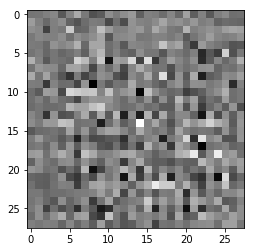

In [41]:
latent = tf.random.normal([BATCH_SIZE, 100])
generated_img = generator(latent)
plt.imshow(generated_img[0,:,:,0], cmap='gray')

### 앞서 생성한 generated_img를 정의해둔 discriminator 에 통과시켜 봅니다.

In [42]:
decision = discriminator(generated_img)
assert decision.shape == (32, 1)

#### generator를 학습시키기 위한 generator loss 함수를 정의합니다.
#### generator가 학습하기 위해서는 discriminator 가 진짜와 generated img를 구분하지 못해야 합니다.
#### 즉 generated img 를 discriminator가 진짜라고 간주해야 합니다.
#### 따라서 fake_output이 진짜 (1) 로 되도록 loss 를 정의합니다. 
##### hint 앞서서 정의한 cross_entropy를 사용합니다.

In [43]:
def generator_loss(fake_output):
    """define generator loss function
    Args:
        fake_output: logit output from discriminator(discriminator's input is generated_img)
    Returns:
        loss: loss value for generator"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

#### discriminator 를 학습시키기 위한 discriminator loss 함수를 정의합니다.
#### discriminator 를 학습하기 위해서는 진짜 이미지와, generated img를 잘 구분해야 합니다.
#### 따라서 real_output은 1로, fake_output은 0 으로 다가가도록 loss 를 정의합니다.
##### hint 앞서서 정의한 cross_entropy를 사용합니다.

In [44]:
def discriminator_loss(real_output, fake_output):
    """define discriminator loss function
    Args:
        real_output: logit output from discriminator(discriminator's input is real img)
        fake_output: logit output from discriminator(discriminator's input is generated_img)
    Returns:
        total_loss: loss value for discriminator """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### 이제 전체적인 학습과정을 정의해 봅시다.
#### generator를 통해 이미지를 생성하고, 정답 이미지와, 생성된 이미지 각각 discriminator에 통과시킨 뒤, 각각의 output을 discriminator_loss 함수에 넣어 discriminator loss 를 구합니다.
#### generator를 통해 생성된 이미지를 generator_loss 함수에 넣어 generator loss 를 구합니다.

In [45]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_imgs = generator(noise, training=True)
        fake_outputs = discriminator(generated_imgs, training=True)
        real_outputs = discriminator(images)
        gen_loss = generator_loss(generated_imgs)
        disc_loss = discriminator_loss(real_outputs, fake_outputs)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    print(f"g_loss == {gen_loss:4.2f} / d_loss == {disc_loss:4.2f}")

#### 학습된 generator를 사용하여 생성해 낸 이미지를 출력합니다.

In [46]:
def generate_and_save_images(epoch, test_input):
    generated_img = generator(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(generated_img.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(denormalized(generated_img[i, :, :, 0]), cmap='gray')
        plt.axis('off')
    plt.savefig(f"saved_img-epoch{epoch}.png")
    plt.show

In [47]:
seed = tf.random.normal([4 * 4, 100])
for epoch in range(5):
    for train_imgs in train_dataset:
        train_step(train_imgs)
        print(f"epoch == {epoch}... printing inference img...")
        display.clear_output(wait=True)
        generate_and_save_images(epoch, seed)

(16, 7, 7, 1024)


AssertionError: 